# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [1]:

# Necessary Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from google.colab import drive


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

# Load the Data
unlabelled_data_path = "/content/drive/MyDrive/unlabelled_sounds"
sound_files = librosa.util.find_files(unlabelled_data_path)
features = []

# extracting features with mel spectrogram
for file in sound_files:
  y, sr = librosa.load(file)
  mel_spectrogram = librosa.feature.melspectrogram(y=y , sr=sr)
  features.append(np.mean(mel_spectrogram, axis =1))

features = np.array(features)


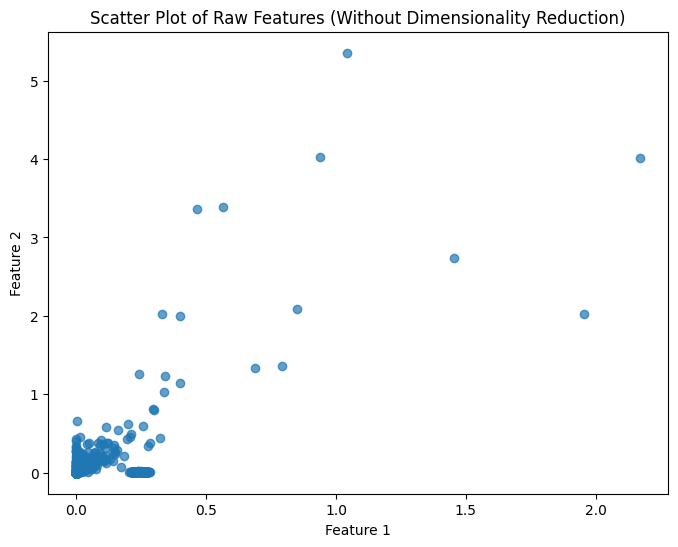

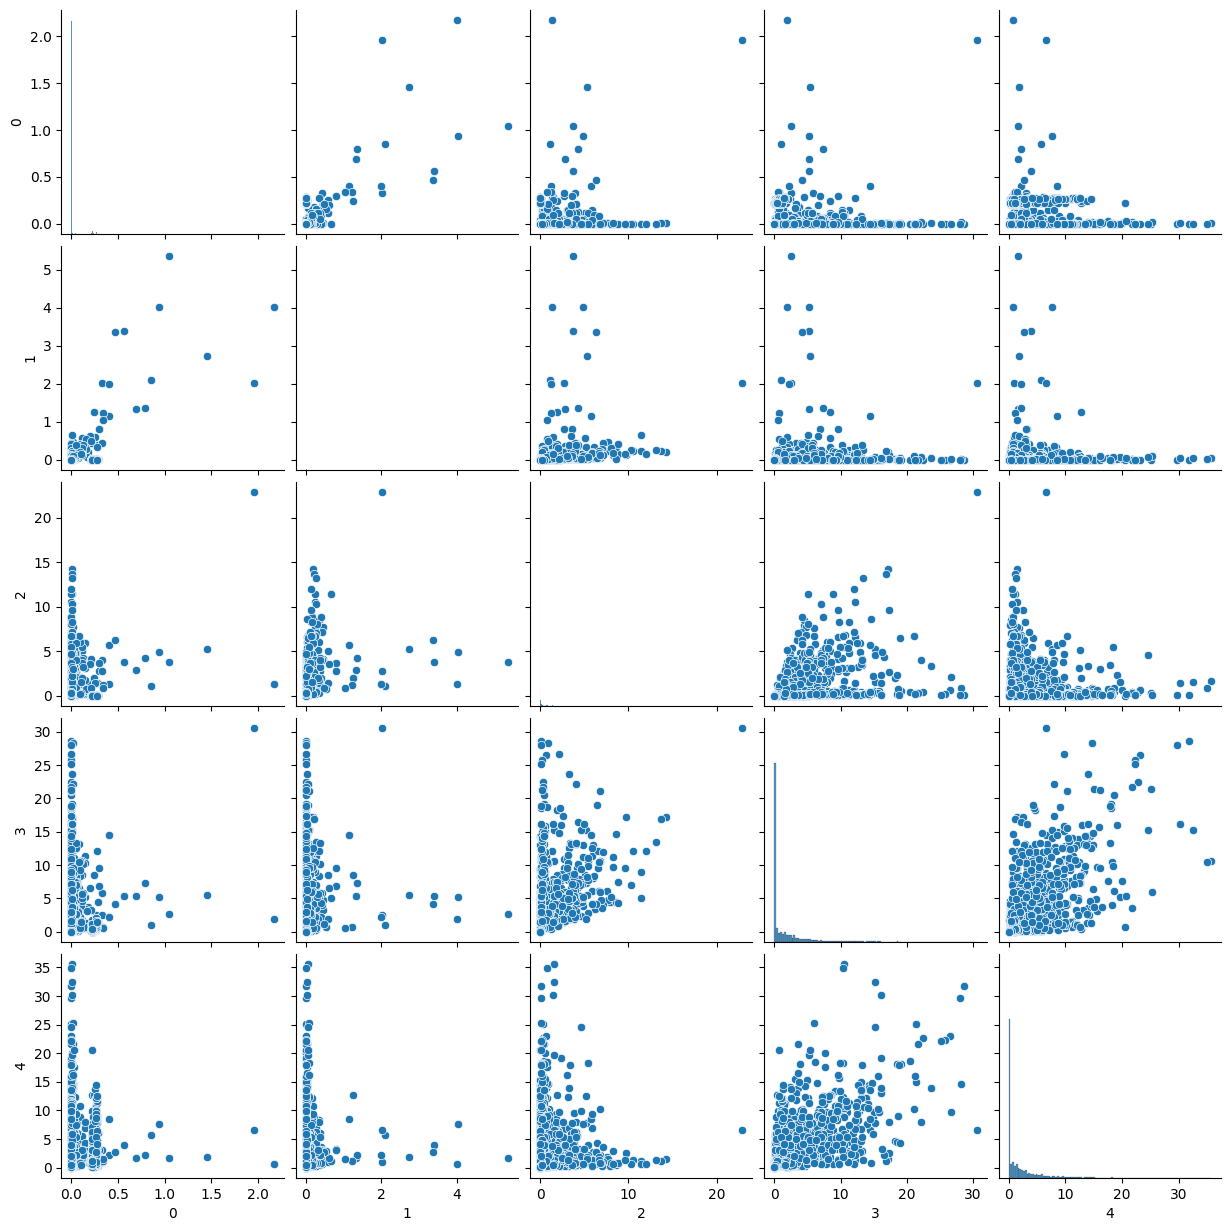

In [4]:

# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(features[:,0], features[:, 1], alpha= 0.7)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot (Only using first 5 features)
df = pd.DataFrame(features[:, :5])
sns.pairplot(df)
plt.show()


### Why is dimensionality reduction important?
Challenges and observations in the experiment are:
1. From the images above, I noticed the datapoints were densely packed and overalapping especially near the lower values and others were also widely scattered so it was hard for me to identify distinct clusters.
2. Another thing i observed was many of the values were clustered near zero with very few large values showing that there was a strong skew in feature distributions as well. And alot of the pair plots exhibit non-linear relationships between features.
3. I also observed that since the dataset had so many features, visualizing it without reducing the dimensions is challenging. The datapoints were also equidistant from each other. I researched on that and found it is referred to as the "Curse of dimensionality."
4. I had to switch to my GPU at some point because the high dimensional datasets also increase the computational cost of clustering algorithms. So I will be applying PCA or t-SNE because they help retain the most important information while reducing noise thereby improving the clustering efficiency.

So given the challenges i observed above, I would say that dimensionality reduction with techniques like the PCA and t-SNE is important because it projects the data into a lower-dimensional space where patterns become more evident. This would help in preserving the meaningful structures and improving the interpretablity of the clusters.

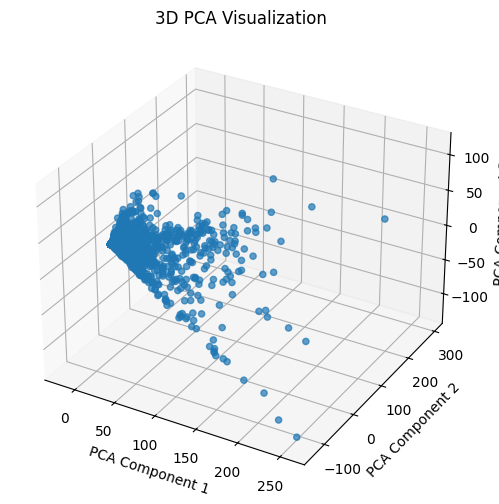

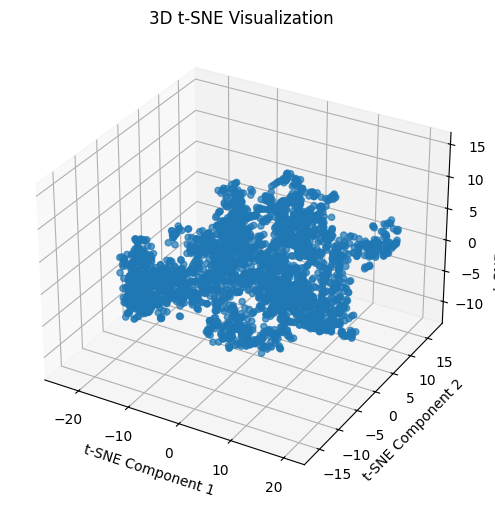

In [5]:
# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, random_state=42)
features_tsne = tsne.fit_transform(features)

# 3D Visualization for PCA
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], alpha=0.7)
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
plt.title("3D PCA Visualization")
plt.show()

# 3D Visualization for t-SNE
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], alpha=0.7)
ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")
ax.set_zlabel("t-SNE Component 3")
plt.title("3D t-SNE Visualization")
plt.show()

### Which method (PCA or t-SNE) provides better separability of clusters and why?
Interpreting visualizations above, the PCA visualization has a broader distribution of points with some in the first principal component. They are not distinctly separated though, meaning the clusters may not really be well defined. It doesnt properly separate the clusters and it may not be effective at distinguishing the local patterns.

On the other hand, observing the t-SNE clustering, there is a more compact clustering of the data points meaning it has better clustering. t-SNE is designed to preserve local structures and non-linear relationships, making it better for visualizing clusters in high-dimensional data.

So in conclusion, t-SNE generally provides better separability of clusters than PCA. And based on the visualizations, t-SNE provides better separability of clusters compared to PCA.



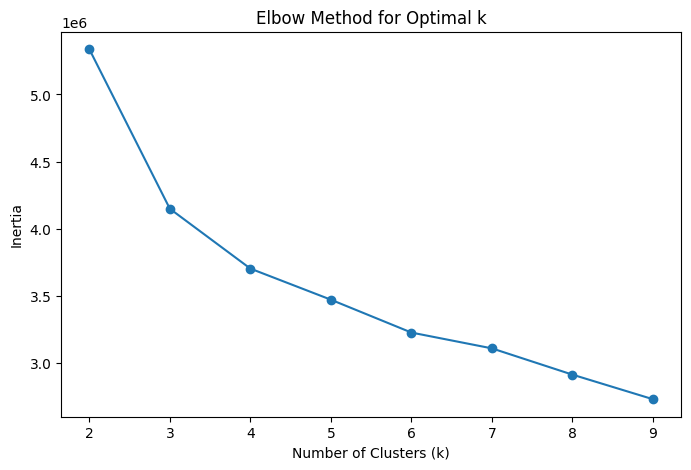

Optimal number of clusters (k) from the Elbow Method: 3


In [6]:
# Optimize number of clusters using Elbow Method

inertia = []
k_values = range (2,10)
for k in k_values:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(features)
  inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

# using this function to detect the elbow point cos it looks close to 3 and 4
def find_elbow_point(k_values, inertia):
    """
    Detects the elbow point in the Elbow Method plot.
    :param k_values: List of k values (number of clusters).
    :param inertia: List of inertia values corresponding to k_values.
    :return: Optimal k (elbow point).
    """
    # the difference in inertia between consecutive k values
    differences = np.diff(inertia)
    # Calculating the relative reduction in inertia
    reduction = differences[:-1] / differences[1:]
    # index of the elbow point
    elbow_index = np.argmax(reduction) + 1  # +1 accounts for the shift due to np.diff
    return k_values[elbow_index]

# prints the optimal k
optimal_k = find_elbow_point(k_values, inertia)
print(f"Optimal number of clusters (k) from the Elbow Method: {optimal_k}")

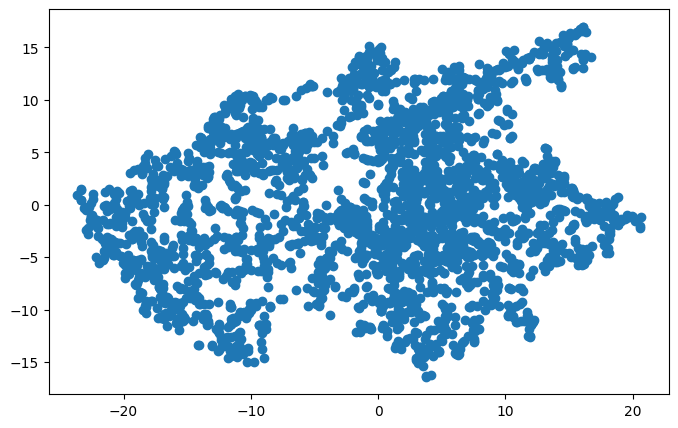

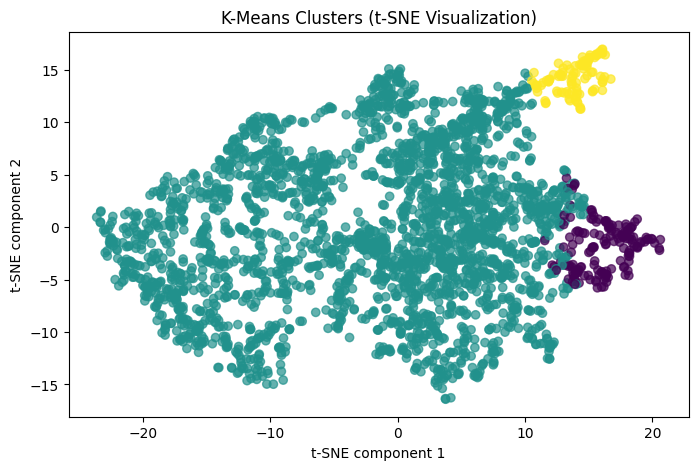

Text(0.5, 1.0, 'DBSCAN Clusters (t-SNE Visualization)')

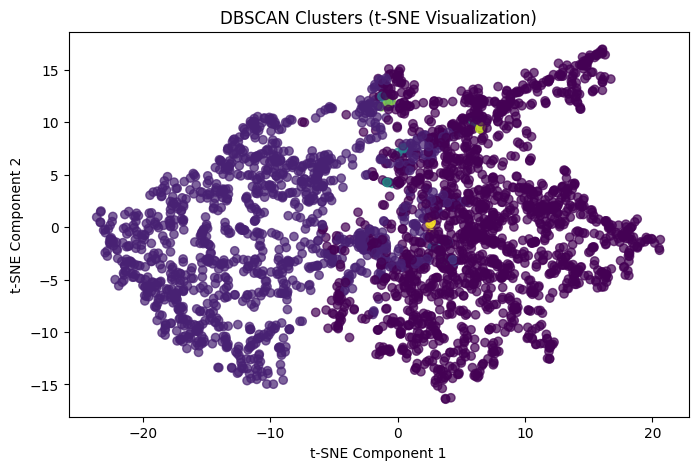

In [7]:

# Select optimal K based on elbow method
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features)

# Scatter Plot for K-Means Clusters
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1])

# Scatter Plot for DBSCAN Clusters
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.title("K-Means Clusters (t-SNE Visualization)")
plt.show()

# Scatter Plot for DBSCAN Clusters
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("DBSCAN Clusters (t-SNE Visualization)")


In [8]:

# Evaluate clustering
kmeans_silhouette = silhouette_score(features, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")


K-Means - Silhouette Score: 0.7005, Davies-Bouldin Index: 1.0313
DBSCAN - Silhouette Score: -0.0305, Davies-Bouldin Index: 1.8554


I also dont know the actual clusters since it wasnt revealed but you can compare it with mine. But based on my metrics and separability in my t-SNE plot, K-means did very well in capturing the meaningful structures in in the data.

### Discuss the Results (My Observations)
K-Means performs well with a Silhouette Score of **0.7005** (good) and a Davies-Bouldin Index of **1.0313** (good), indicating compact and well-separated clusters. DBSCAN performs poorly with a Silhouette Score of **-0.0305** (bad) and a Davies-Bouldin Index of **1.8554** (bad), suggesting it failed to form meaningful clusters. K-Means is more suitable for this dataset due to its ability to handle spherical clusters, while DBSCAN struggles with varying densities and parameter sensitivity. Dimensionality reduction (e.g., t-SNE) improved clustering quality by projecting data into a lower-dimensional space, making clusters more separable and interpretable.

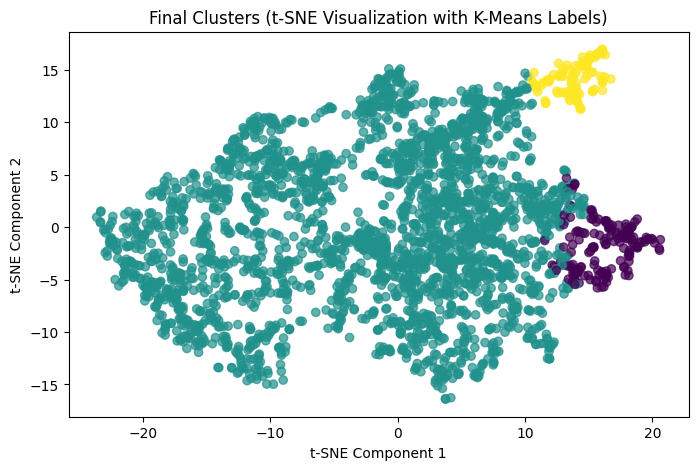

In [9]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis

1. **Why Dimensionality Reduction Helped:**
   - Dimensionality reduction techniques like PCA and t-SNE were essential for improving the interpretability and separability of clusters. High-dimensional data (e.g., Mel Spectrogram features) is challenging to visualize and analyze directly due to the "curse of dimensionality." By reducing the dimensions, we preserved the most meaningful structures in the data, making it easier to identify clusters and patterns.

2. **Why Certain Clustering Methods Worked Better:**
   - **K-Means** performed well because it is designed to handle spherical clusters and works effectively when the number of clusters (`k`) is known or can be estimated (e.g., using the elbow method). Its performance is reflected in the high Silhouette Score (0.7005) and low Davies-Bouldin Index (1.0313), indicating compact and well-separated clusters.
   - **DBSCAN** struggled because it is sensitive to parameter choices (e.g., `eps` and `min_samples`) and performs poorly when clusters have varying densities. The negative Silhouette Score (-0.0305) and high Davies-Bouldin Index (1.8554) suggest that DBSCAN failed to form meaningful clusters for this dataset.

3. **Real-World Clustering Challenges:**
   - In real-world scenarios, clustering unlabeled data (e.g., sound recordings) often involves high-dimensional features and unknown cluster structures. Dimensionality reduction is critical for making the data interpretable, and the choice of clustering algorithm depends on the data's characteristics (e.g., density, shape, and size of clusters). This assignment highlights the importance of experimenting with multiple techniques and evaluating their performance using metrics like Silhouette Score and Davies-Bouldin Index.